In [2]:
import numpy as np
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
SIZE = 28
meta = pd.read_csv('metadata.csv', delimiter=',')
data = np.loadtxt(f'hmnist_{SIZE}_{SIZE}_L.csv', delimiter=',', skiprows=1, usecols=range(SIZE * SIZE))


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, meta.dx, test_size=0.2, random_state=42)

y_train_old = y_train

smote = SMOTE(k_neighbors=10)
X_train, y_train = smote.fit_resample(X_train, y_train)

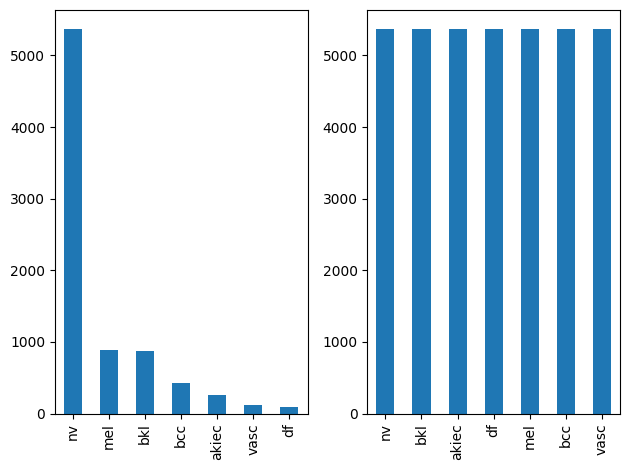

In [5]:
fig = plt.figure()
plt.subplot(1, 2, 1)
y_train_old.value_counts().plot(kind="bar")
plt.subplot(1, 2, 2)
y_train.value_counts().plot(kind="bar")

fig.tight_layout()

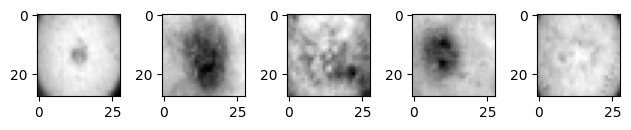

In [6]:
fig = plt.figure()

X_images = np.apply_along_axis(lambda row: np.split(row, SIZE), arr=X_train, axis=1)

for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow(X_images[23000 + i], cmap="gist_gray")

fig.tight_layout()

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.fit_transform(y_test))

In [8]:
X_tr = np.array(X_train).reshape(len(X_train), SIZE, SIZE)
X_test = np.array(X_test).reshape(len(X_test), SIZE, SIZE)


X_tr = X_tr[:, :, :, None]
X_test = X_test[:, :, :, None]

In [9]:
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout 25% of the nodes of the previous layer during training
model.add(Flatten())     # Flatten, and add a fully connected layer
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax')) # Last layer: 10 class nodes, with dropout
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                        

In [10]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(X_tr, y_train_encoded, epochs=50, batch_size=32, validation_split=1/6)

Epoch 1/50
979/979 [==============================] - 10s 10ms/step - loss: 1.8693 - accuracy: 0.3287 - val_loss: 4.6677 - val_accuracy: 0.0291
Epoch 2/50
979/979 [==============================] - 9s 10ms/step - loss: 1.2825 - accuracy: 0.4900 - val_loss: 4.3252 - val_accuracy: 0.0790
Epoch 3/50
979/979 [==============================] - 9s 9ms/step - loss: 1.0087 - accuracy: 0.6048 - val_loss: 4.0358 - val_accuracy: 0.0945
Epoch 4/50
680/979 [===================>..........] - ETA: 2s - loss: 0.8607 - accuracy: 0.6651

KeyboardInterrupt: 

In [ ]:
test = model.evaluate(X_test, y_test_encoded)

63/63 [==============================] - 0s 2ms/step - loss: 1.9820 - accuracy: 0.6445
